# **Evaluation Function**

In [1]:
video_L = None
video_R = None
snapshot_L = None
snapshot_R = None

def evaluate(model, batch):
    global video_L, video_R, snapshot_L, snapshot_R
    
    # 0) Convert to Gray
    def rgb_to_gray(x):
        weights = torch.tensor([0.2989, 0.5870, 0.1140], dtype=x.dtype, device=x.device)
        gray = (x * weights[None, None, :, None, None]).sum(dim=2)
        return gray # -- shape: [B, T, H, W]
    
    video_L = rgb_to_gray(batch["img"][:, :, 0]) # ~ (b, t, h, w)
    video_R = rgb_to_gray(batch["img"][:, :, 1]) # ~ (b, t, h, w)
    
    # 1) Extract and normalize input videos.
    # -- min_max_norm = lambda x : 2. * (x / 255.) - 1.
    min_max_norm = lambda x: x / 255.
    video_L = min_max_norm(video_L) # ~ (b, t, h, w)
    video_R = min_max_norm(video_R) # ~ (b, t, h, w)
    
    # 2) If the tensor is non-contiguous and we try .view() later, PyTorch will raise an error:
    video_L = video_L.contiguous()
    video_R = video_R.contiguous()
    
    # 3) Coded exposure modeling.
    snapshot_L = model.sci_enc_L(video_L) # ~ (b, c, h, w) -- c=2 for 2 taps
    snapshot_R = model.sci_enc_R(video_R) # ~ (b, c, h, w) -- c=2 for 2 taps
    
    # 4) Dynamic Stereo
    output = {}
    
    disparities = model.stereo(
        snapshot_L,
        snapshot_R,
        iters=10,
        test_mode=False
    )

    snapshot_L = snapshot_L.detach().numpy()
    snapshot_R = snapshot_R.detach().numpy()
    
    return disparities

# **Model Setup and Testing on Dynamic Stereo Real-World Dataset** 

In [14]:
import sys
import torch

sys.path.append("../")

import datasets.dynamic_stereo_datasets as datasets
from train import wrapper

model = wrapper(sigma_range=[0, 1e-9],
                num_frames=8,
                in_channels=1,
                n_taps=2,
                resolution=[480, 640],
                mixed_precision=True,
                attention_type="self_stereo_temporal_update_time_update_space",
                update_block_3d=True,
                different_update_blocks=True,
                train_iters=8)

ckpt_path = "../dynamicstereo_sf_dr/model_dynamic-stereo_010179.pth"
state_dict = torch.load(ckpt_path, map_location=torch.device('cpu'))
model.load_state_dict(state_dict["model"], strict=True)
model.eval()

for seq_name in ["teddy_static", "ignacio_waving", "nikita_reading"]:
    real_dataset = datasets.DynamicReplicaDataset(split="test",
                                                  sample_len=8,
                                                  root="../dynamic_replica_data/real/{}".format(seq_name),
                                                  only_first_n_samples=1,
                                                  t_step_validation=4)
    break

for batch in real_dataset:
    batch["img"] = batch["img"].view(1, *batch["img"].shape)
    disparities = evaluate(model, batch)

seq_len teddy2_sample_new 218
Added 1 from Dynamic Replica test


## **Disparity Maps (Left Aligned)**

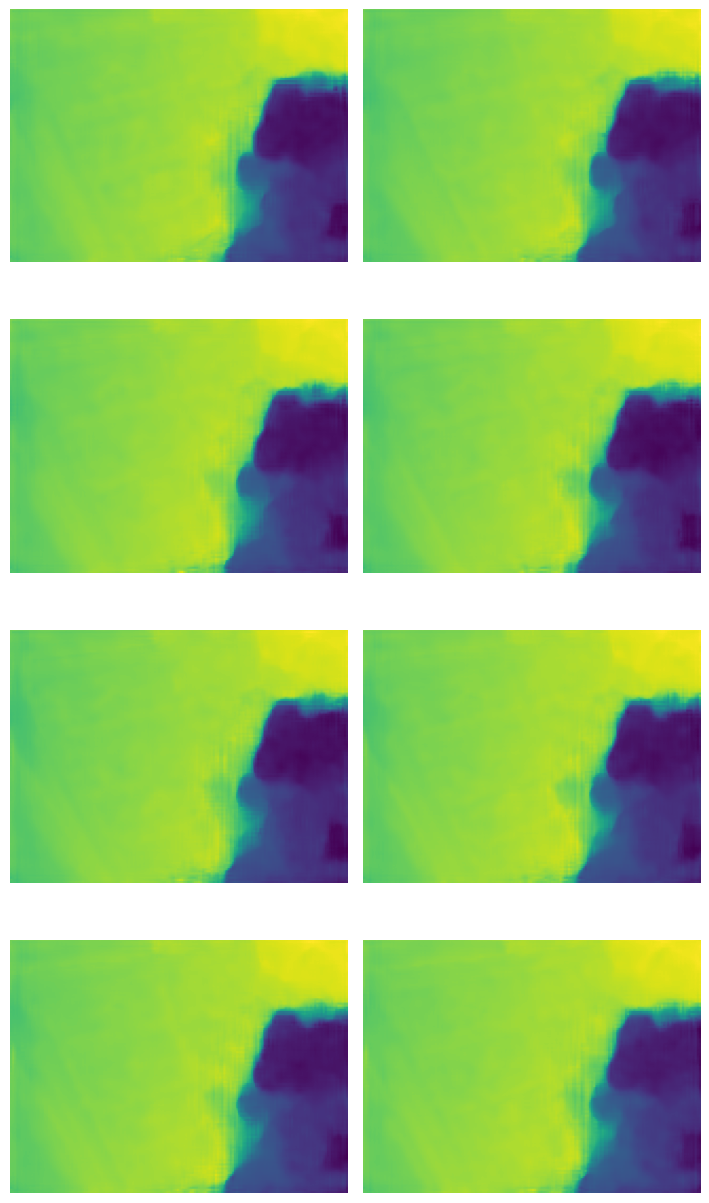

In [12]:
import matplotlib.pyplot as plt
import numpy as np

disparities = disparities.detach().cpu()

fig, axes = plt.subplots(4, 2, figsize=(7.2, 12.8))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(disparities[-1, i, 0, 0], cmap="viridis")
    ax.axis("off")
plt.tight_layout()
plt.show()

# **Video (Left View)**

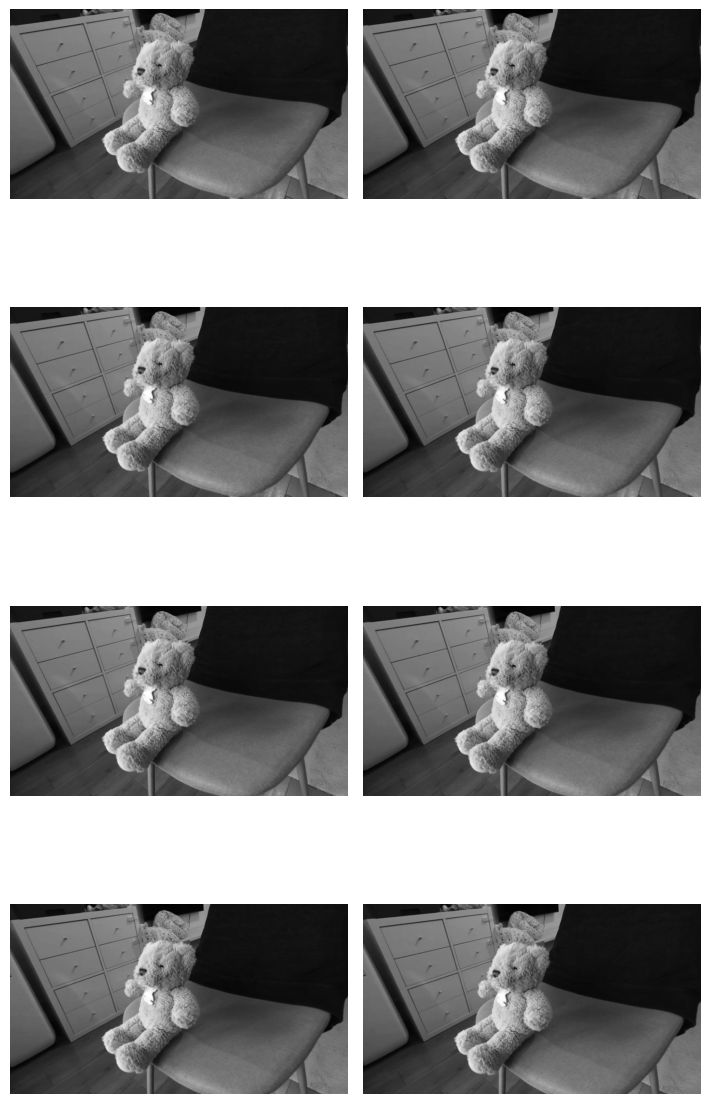

In [10]:
fig, axes = plt.subplots(4, 2, figsize=(7.2, 12.8))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(video_L[0, i], cmap="gray")
    ax.axis("off")
plt.tight_layout()
plt.show()

# **Video (Right View)**

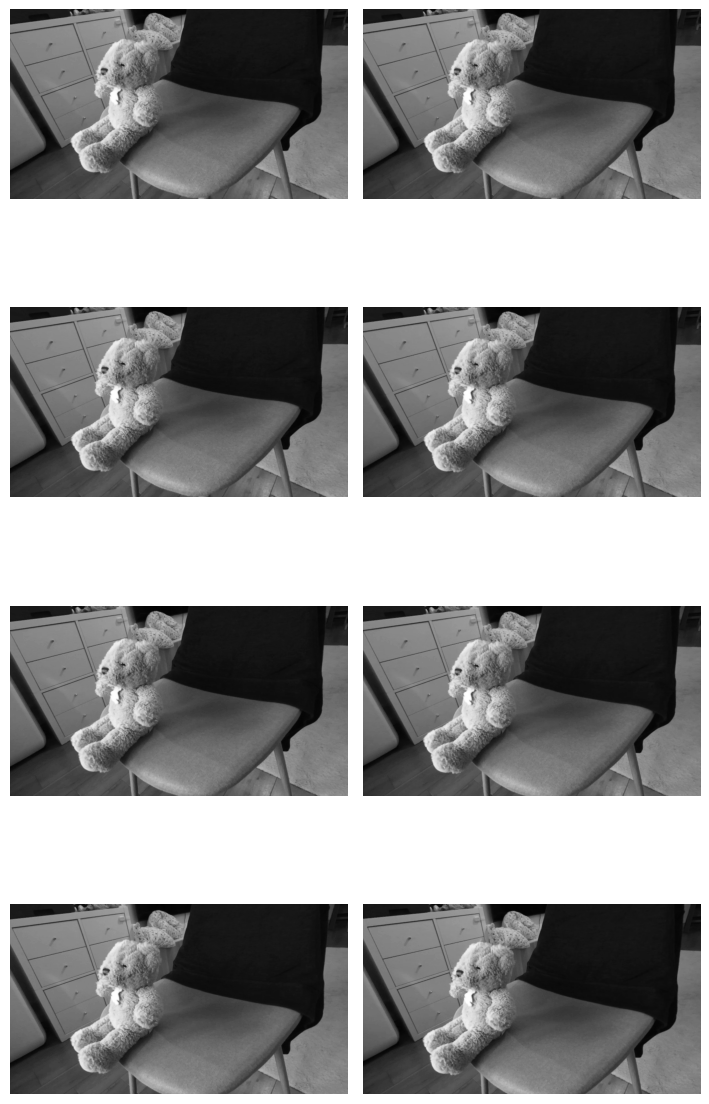

In [8]:
fig, axes = plt.subplots(4, 2, figsize=(7.2, 12.8))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(video_R[0, i], cmap="gray")
    ax.axis("off")
plt.tight_layout()
plt.show()

# **Snapshots and Shutter Code (Left View)**

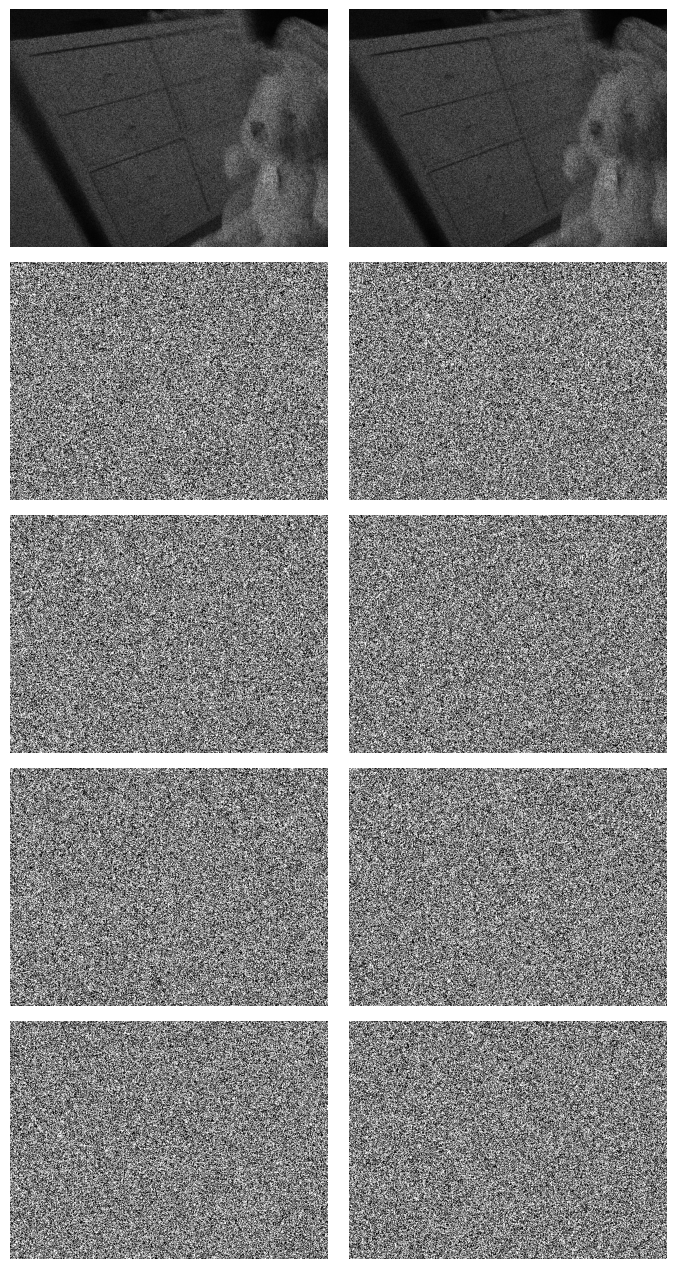

In [23]:
fig, axes = plt.subplots(5, 2, figsize=(7.2, 12.8))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(snapshot_L[0, i], cmap="gray")
    ax.axis("off")
plt.tight_layout()
plt.show()

# **SCI Encoder's Weights (Left)**

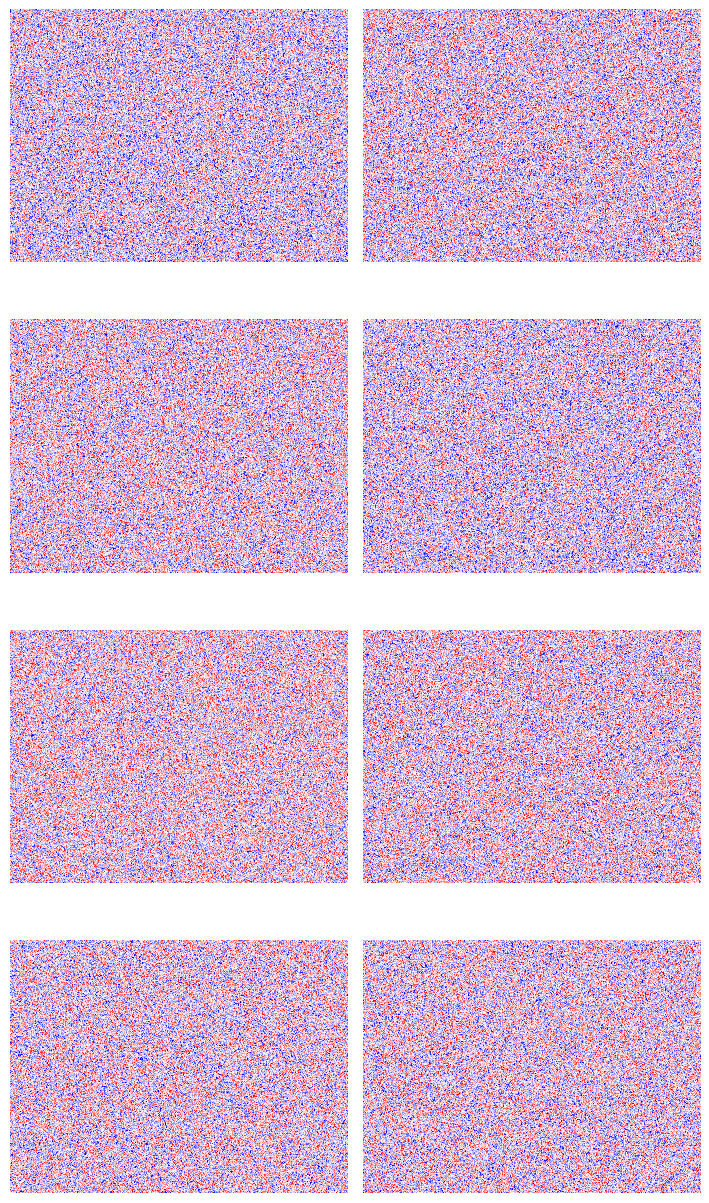

In [30]:
fig, axes = plt.subplots(4, 2, figsize=(7.2, 12.8))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(model.sci_enc_L.ce_weight.detach().numpy()[i, 0], cmap="seismic")
    ax.axis("off")
plt.tight_layout()
plt.show()

# **Snapshots and Shutter Code (Right View)**

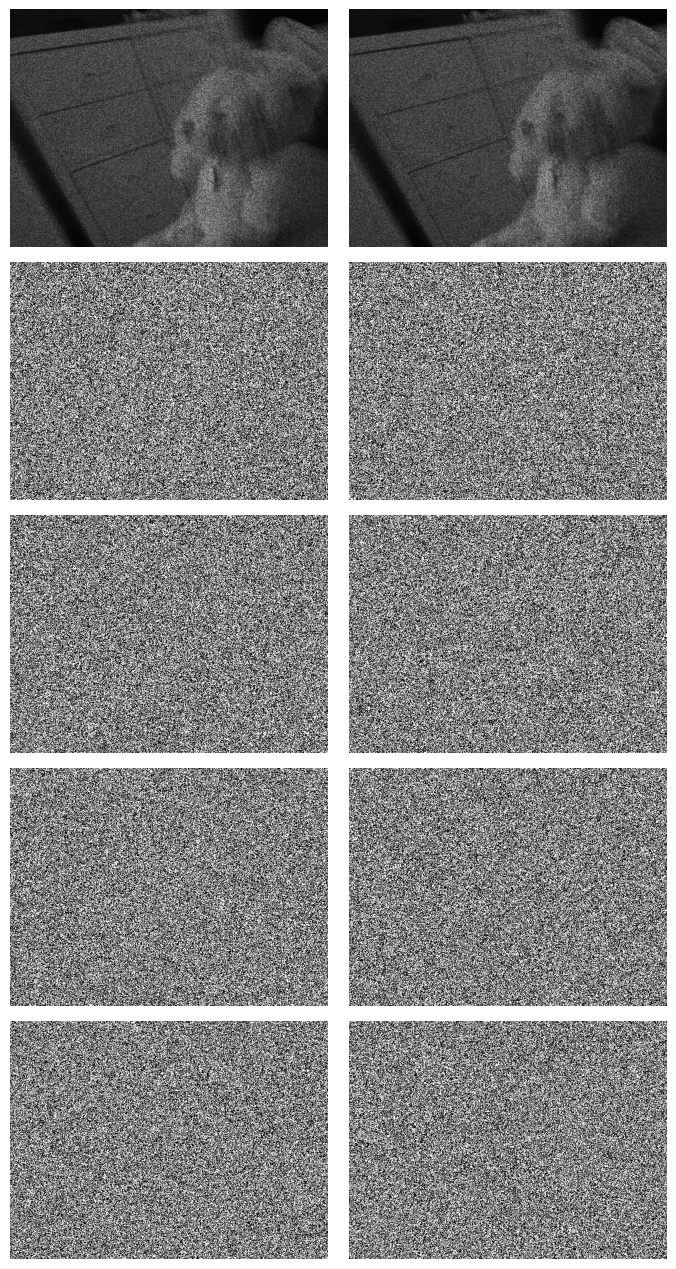

In [24]:
fig, axes = plt.subplots(5, 2, figsize=(7.2, 12.8))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(snapshot_R[0, i], cmap="gray")
    ax.axis("off")
plt.tight_layout()
plt.show()

# **SCI Encoder's Weights (Right)**

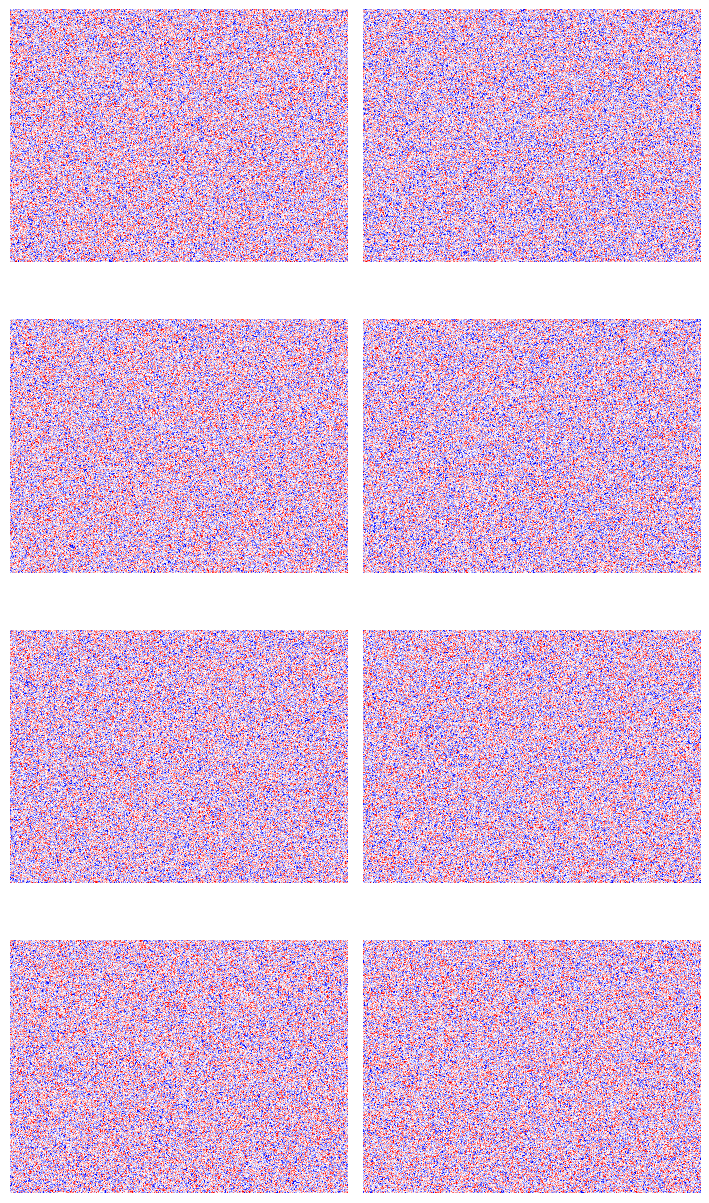

In [32]:
fig, axes = plt.subplots(4, 2, figsize=(7.2, 12.8))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(model.sci_enc_R.ce_weight.detach().numpy()[i, 0], cmap="seismic")
    ax.axis("off")
plt.tight_layout()
plt.show()